#### Joar Solvang - Master's Thesis 02/03/2021

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle 
import sys
import seaborn as sb
import math
from numpy import random
from scipy.signal import find_peaks
sys.path.append(r'C:\Users\Joar\Documents\1_Education\NTNU\OneDrive - NTNU\Thesis\Modelling\FD Model')

In [2]:
from FloaterParameters import FloaterParameters
from Environment import Environment
from Buoy import Buoy
from Mass import Mass
from Density import Density
from Area import Area
from GeneralisedCoordinateSystem import GeneralisedCoordinateSystem
from SystemMatrices import MatrixCalculation
from ComputeHydroCoefficients import CompHydroCoefficient
from plot_hydroD_results import plot_hydroD_results
from ReadWadamLis import ReadWadamLis
from CheckInterpolation import InterpolateParameters
from jonswap import jonswap
from RAO_Calculation import calulate_RAOs
from kSolve import ksolve
from SpectrumStatistics import spectrum_response 
from InterpolateHydroDResults import InterpolateResults
from StaticThrustCheck import StaticThrustCheck
from WindForceSpectrum import WindForceSpectrum

Unable to import mpi4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.
Unable to import petsc4py. Parallel processing unavailable.


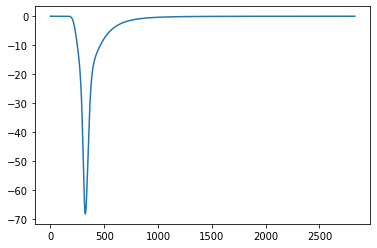

In [27]:
plt.plot(s/(2*np.pi) - s_rad)

# Frequency Domain Analysis

#### Importing System Matrices

In [3]:
pull = np.array([[60,80,12]])
file_loc = r'C:\Users\Joar\Documents\1_Education\NTNU\pickle_files'
file_name = "\sim_x_%d_y_%d_D%d" % (pull[0,0],pull[0,1],pull[0,2])
file_path = file_loc + file_name
infile = open(file_path,'rb')
sim = pickle.load(infile)
infile.close()

#### Hand Calculations

In [4]:
mufp = FloaterParameters(pull[0,0],pull[0,1],pull[0,2])
env = Environment()
rho = Density()
csa = Area(mufp)
buoy = Buoy(mufp, csa, rho)
mass = Mass(mufp, csa, buoy, rho)
coord = GeneralisedCoordinateSystem(mufp, csa, mass, rho, buoy, env)
matrix = MatrixCalculation(coord, mass, mufp, rho, env, csa, buoy)

#### Calculating System RAO's

In [5]:
plot = 0
hydroD_data = 0
df = 1/3600
df_rad = (2*np.pi)*df
f = np.arange(0.01,5,df)

In [6]:
sim_interp = InterpolateResults(sim.wave_disc, sim.WAVEEX, sim.MOTIONS, sim.ADDEDMASS, sim.DAMPING, f)

In [7]:
if hydroD_data == 0:
    X_interp = calulate_RAOs(sim_interp.wave_disc, matrix.mass, sim_interp.ADDEDMASS, sim_interp.DAMPING, matrix.stiffness, sim_interp.WAVEEX, sim_interp.MOTIONS, plot, mufp, coord)
else:
    X_interp = calulate_RAOs(sim_interp.wave_disc, sim.mass_matrix, sim_interp.ADDEDMASS, sim_interp.DAMPING, sim.stiffness_matrix, sim_interp.WAVEEX, sim_interp.MOTIONS, plot, mufp, coord)

In [8]:
if hydroD_data == 0:
    X = calulate_RAOs(sim.wave_disc, matrix.mass, sim.ADDEDMASS, sim.DAMPING, matrix.stiffness, sim.WAVEEX, sim.MOTIONS, plot, mufp, coord)
else:
    X = calulate_RAOs(sim.wave_disc, sim.mass_matrix, sim.ADDEDMASS, sim.DAMPING, sim.stiffness_matrix, sim.WAVEEX, sim.MOTIONS, plot, mufp, coord)

In [9]:
Y_lab = ["RAO Surge, [m/m]",
         "RAO Sway, [m/m]",
         "RAO Heave, [m/m]",
         "RAO Roll, [rad/m]",
         "RAO Pitch, [rad/m]",
         "RAO Yaw, [rad/m]",
         "RAO Nacelle For-aft [m/m]",
         "RAO Nacelle Side-Side [m/m]"]
styles = ['b', 'g', 'r', 'm', 'c', 'k']

In [10]:
matrix.stiffness[0,0] = 1e6
matrix.stiffness[1,1] = 1e6
matrix.stiffness[5,5] = 1e9

In [11]:
# np.linspace(0, 5, 6).astype(int):
DOF = [0,2,4]

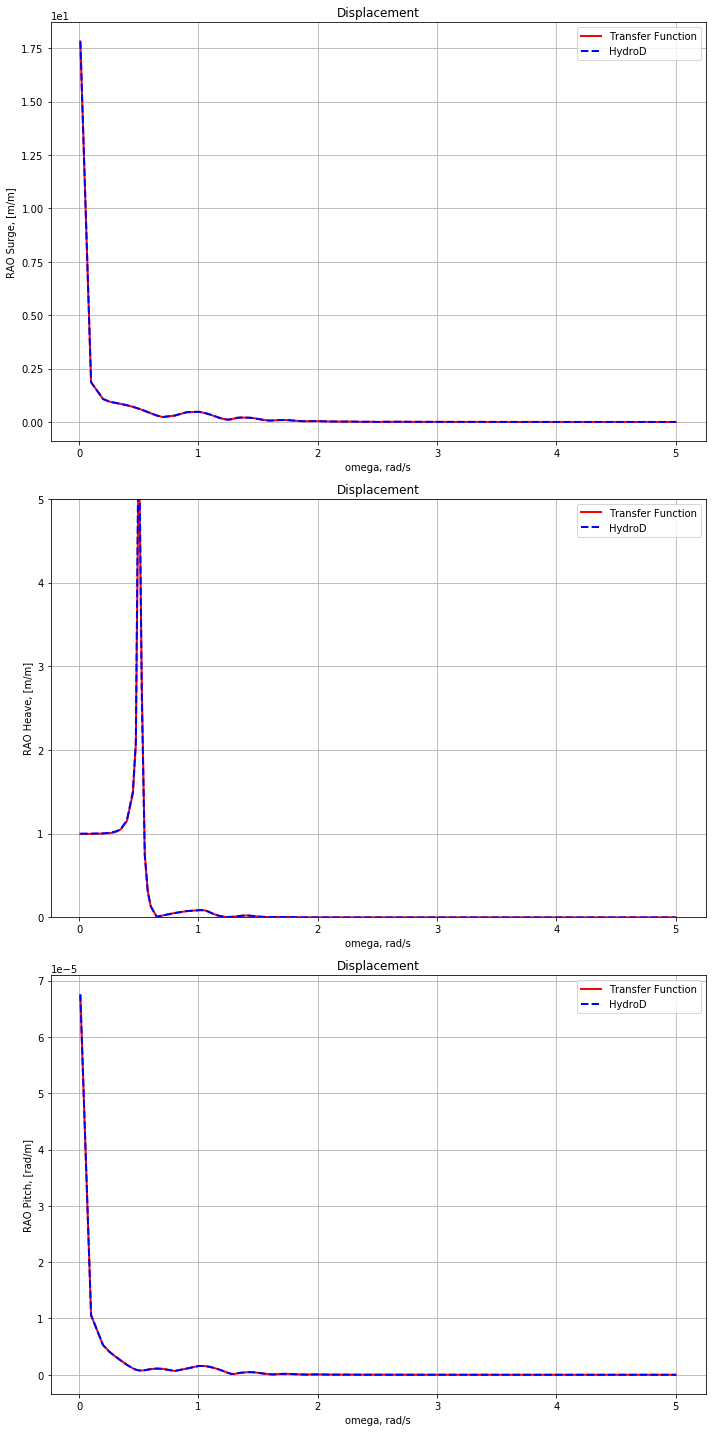

In [12]:
plt.rcParams["figure.figsize"] = (10, 20)
fig, axs = plt.subplots(len(DOF))
for jj in np.linspace(0, len(DOF)-1, len(DOF)).astype(int):
    axs[jj].plot(sim.wave_disc[:, 4], np.absolute(X[0, :, DOF[jj]]), 'r', label='Transfer Function', linewidth=2,
                 markersize=5)
    axs[jj].plot(sim.wave_disc[:, 4], sim.MOTIONS[0,:,DOF[jj],2], '--b', label='HydroD', linewidth=2,
                 markersize=5)
    #axs[jj].plot(sim_interp.wave_disc[:, 4], np.absolute(X_interp[0, :, DOF[jj]]), 'g', label='Transfer Function Interpolate', linewidth=2,
    #     markersize=5)
    axs[jj].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    axs[jj].set(xlabel='omega, rad/s', ylabel=Y_lab[DOF[jj]], title="Displacement")
    axs[jj].legend(loc="upper right")
    axs[jj].grid(b=True, which='both', axis='both')
    
    
    #ax2 = axs[jj].twinx() 
    #ax2.set_ylabel(Y_lab[jj], color='tab:blue')  # we already handled the x-label with ax1
    #
    
    
axs[1].set(ylim =[0,5])   
#axs[2].set(ylim =[0,5e-6]) 
#axs[3].set(ylim =[0,5e-4]) 
plt.tight_layout()

#### Jonswap Spectrum

In [13]:
Hs = 8.31
Tp = 10
gammaJS = 3.3
df = 1/3600
df_rad = (2*np.pi)*df
f = np.arange(0.01,5,df_rad)
omega = f*(2*np.pi)
k = np.zeros(len(omega))
plot = 0

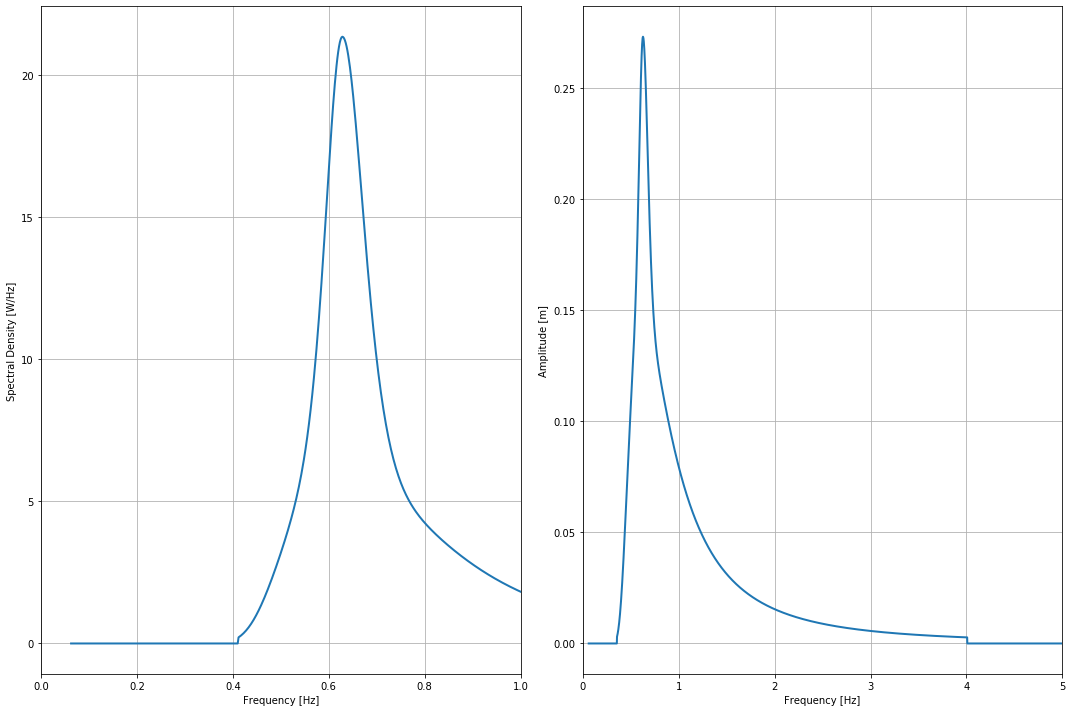

In [14]:
[s, A] = jonswap(Hs, Tp, df, gammaJS, f, 1)

To follow this process intuitively, a time series will be plotted

## 1. Define Variables
- We'll look at a 3 hour period
- Significant Amplitude
- Most probably amplitude
- Maximum expected amplitude

### Calculating Response Spectra

3 hours in seconds

In [15]:
f

array([0.01      , 0.01027778, 0.01055556, ..., 4.99916667, 4.99944444,
       4.99972222])

Defining variables

## The response spectrum can be found by using the following equations

In [16]:
file_loc = r'C:\Users\Joar\Documents\1_Education\NTNU\pickle_files'

In [17]:
Tr = 3*3600   # 3 hour return period
Tz = np.zeros(shape = (len(pull), 3,8))
Significant_Amplitude = np.zeros(shape = (len(pull), 3,8))
N_mpm = np.zeros(shape = (len(pull), 3,8))
MPM = np.zeros(shape = (len(pull), 3,8))
X_sep = np.zeros(len(pull))
response = np.zeros(shape=(len(pull), 3, len(s), 8))
m0 = np.zeros(shape=(len(pull), 3, 8))
m1 = np.zeros(shape=(len(pull), 3, 8))
m2 = np.zeros(shape=(len(pull), 3, 8))
Deflection = np.zeros(len(pull))

In [18]:
plot = 1

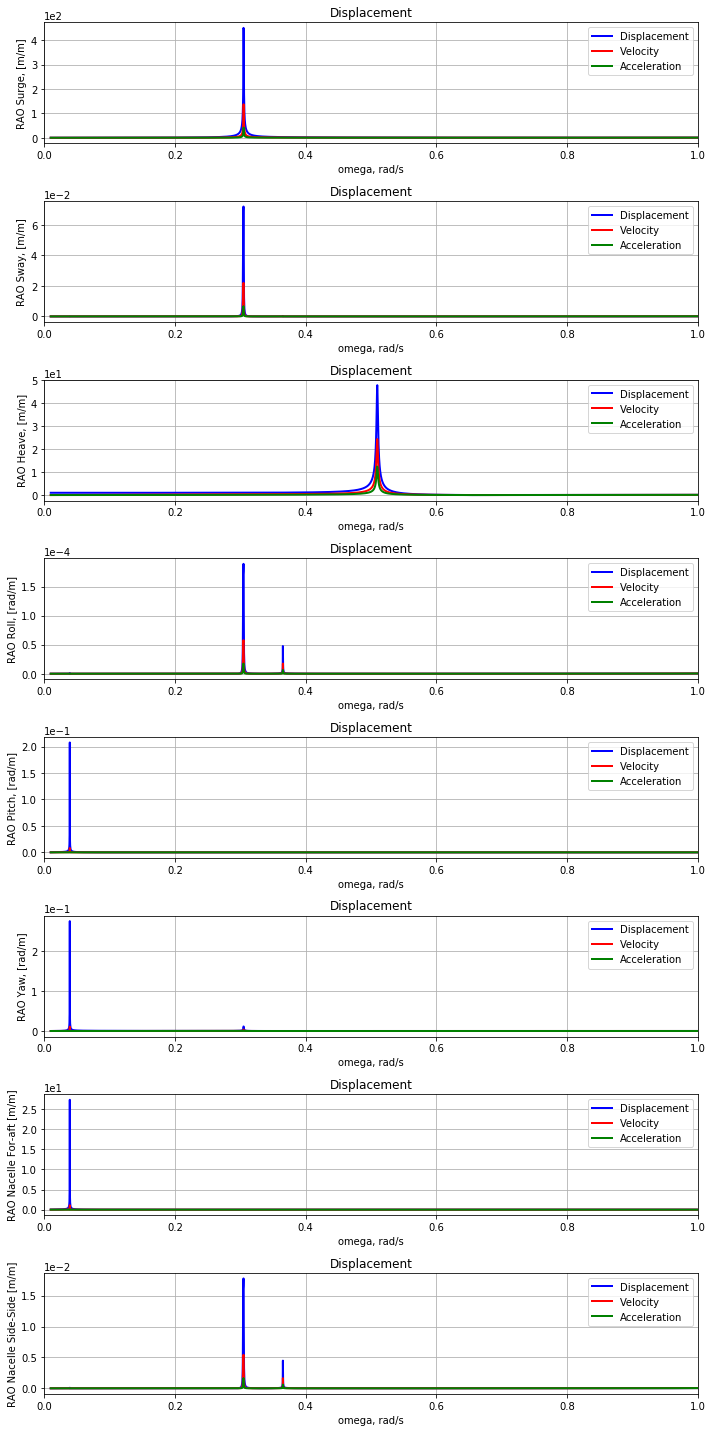

In [19]:
for jj in np.linspace(0, len(pull)-1, len(pull)).astype(int):
    file_name = "\sim_x_%d_y_%d_D%d" % (pull[jj,0],pull[jj,1],pull[jj,2])
    file_path = file_loc + file_name
    X_sep[jj] = pull[jj,0]
    infile = open(file_path,'rb')
    sim = pickle.load(infile)
    RAO = calulate_RAOs(sim_interp.wave_disc, matrix.mass, sim_interp.ADDEDMASS, sim_interp.DAMPING, matrix.stiffness, sim_interp.WAVEEX, sim_interp.MOTIONS, plot, mufp, coord)
    Tz[jj,:,:], Significant_Amplitude[jj,:,:], N_mpm[jj,:,:], MPM[jj,:,:], response[jj,:,:,:], m0[jj,:], m1[jj,:], m2[jj,:] = spectrum_response(s, Tr, RAO, sim, f, df_rad)
    Deflection[jj] = StaticThrustCheck(matrix.stiffness, mufp)

In [20]:
Tz[0,1,:]

array([30.88477639, 30.37267171, 44.56413215, 33.06151687, 65.67968378,
       51.86717096, 65.67968378, 33.06151687])

In [21]:
pd.DataFrame(Tz[0,:,:])

,0,1,2,3,4,5,6,7
0,35.804709,35.136405,52.562723,39.313334,68.480177,58.540288,68.480177,39.313334
1,30.884776,30.372672,44.564132,33.061517,65.679684,51.867171,65.679684,33.061517
2,28.633274,28.295670,37.157704,29.863699,62.772819,43.412028,62.772819,29.863699


In [22]:
DOF = 2
DoF = 'Heave'

In [23]:
A = [["Displacement",Tz[:,0,DOF][0], Significant_Amplitude[:,0,DOF][0],N_mpm[:,0,DOF][0], MPM[:,0,DOF][0]],
    ["Velocity", Tz[:,1,DOF][0], Significant_Amplitude[:,1,DOF][0],N_mpm[:,1,DOF][0], MPM[:,1,DOF][0]],
    ["Acceleration", Tz[:,2,DOF][0], Significant_Amplitude[:,2,DOF][0],N_mpm[:,2,DOF][0], MPM[:,2,DOF][0]]]

In [24]:
A = pd.DataFrame(A)
A.columns = [DoF,'Tz', 'Hs', 'N_MPM', "MPM"]
A.set_index(DoF)

,Tz,Hs,N_MPM,MPM
Heave,,,,
Displacement,52.562723,8.185295,205.468807,6.678226
Velocity,44.564132,0.978445,242.347365,0.810573
Acceleration,37.157704,0.137953,290.653052,0.116161


In [25]:
A = np.transpose([X_sep, Tz[:,0,DOF], Significant_Amplitude[:,0,DOF], N_mpm[:,0,DOF], MPM[:,0,DOF]])
A = pd.DataFrame(A)
A.columns = ['X Seperation', 'Tz', 'Hs', 'N_MPM', "MPM"]
A.set_index('X Seperation')

,Tz,Hs,N_MPM,MPM
X Seperation,,,,
60.0,52.562723,8.185295,205.468807,6.678226


In [26]:
DOF = 2

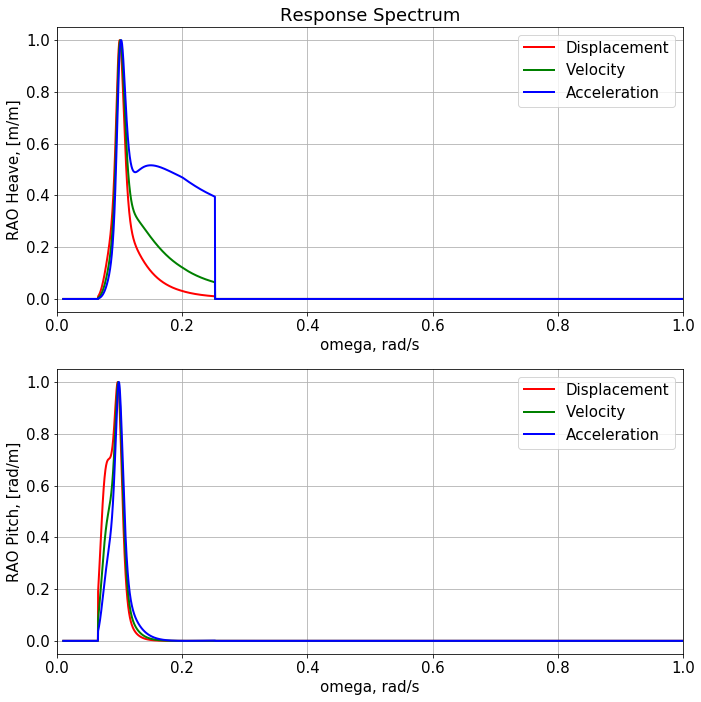

In [27]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams.update({'font.size': 15})
plot_dof = [2,4]
fig, axs = plt.subplots(len(plot_dof))

for x,jj in enumerate(plot_dof):
    axs[x].plot(f, response[0,0,:,jj]/max(response[0,0,:,jj]), '-r', label="Displacement", linewidth=2,
                 markersize=5)
    axs[x].plot(f, response[0,1,:,jj]/max(response[0,1,:,jj]), '-g', label="Velocity", linewidth=2,
                 markersize=5)
    axs[x].plot(f, response[0,2,:,jj]/max(response[0,2,:,jj]), '-b', label="Acceleration", linewidth=2,
                 markersize=5)
    axs[0].set(title="Response Spectrum")
    axs[x].set(xlabel='omega, rad/s', ylabel = Y_lab[jj])
    axs[x].legend(loc="upper right")
    axs[x].ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    axs[x].grid(b=True, which='both', axis='both')
    axs[x].set(xlim=[0,1])
plt.tight_layout()